# 01 – Data Collection & Exploration

'''This notebook explores the pre-market stock data collected using `fetch_and_save_premarket.py`.

- Load the latest pre-market data  
- Visualize gap percentages  
- Begin identifying patterns in movers'''


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openai
import os
import yfinance as yf
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


# Load premarket data
df = pd.read_csv('../data/daily_report.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df

ticker  prev_close    open  gap_pct                  timestamp
0   NVDA      158.24  159.33     0.69 2025-07-08 14:42:14.568269
1   TSLA      293.94  296.88     1.00 2025-07-08 14:42:14.747683
2   AAPL      209.95  210.13     0.09 2025-07-08 14:42:15.020752
3    AMD      134.80  137.34     1.88 2025-07-08 14:42:15.170424
4   MSFT      497.72  497.41    -0.06 2025-07-08 14:42:15.348097

### What is a Gap?

''' A **gap** occurs when a stock opens significantly higher or lower than its previous day's closing price.  
This project uses `gap_pct` to detect such movements.

**Formula:** gap_pct = ((open - prev_close) / prev_close) * 100


- **Gap Up**: Bullish move → opens higher than it closed
- **Gap Down**: Bearish move → opens lower than it closed

We use this to find stocks likely to show momentum early in the trading day — ideal setups for options trades.

'''


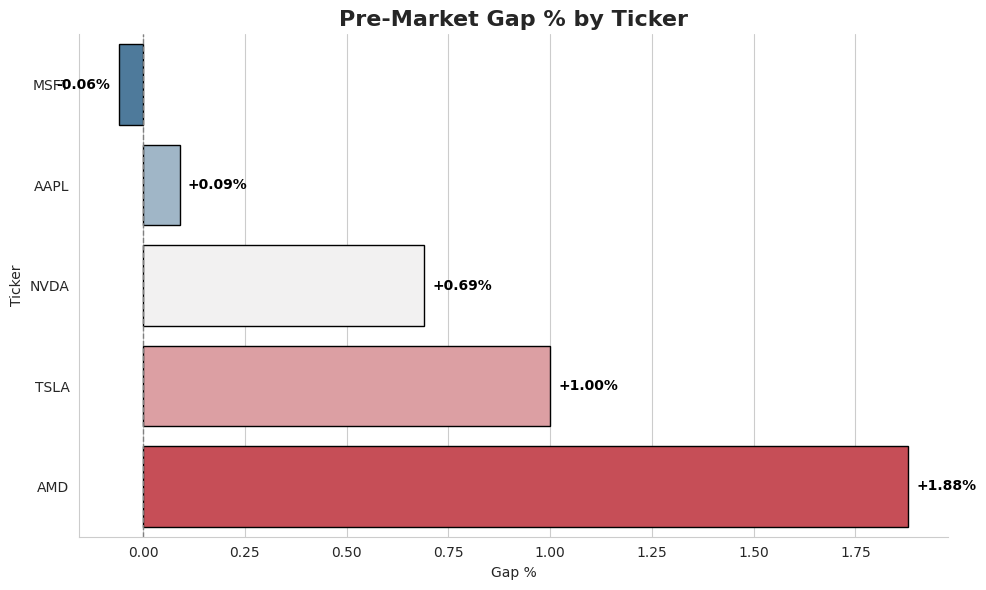

In [5]:
# Sort by gap % and reset index
df_sorted = df.sort_values('gap_pct').reset_index(drop=True)

# Plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

barplot = sns.barplot(
    data=df_sorted,
    x='gap_pct',
    y='ticker',
    palette=sns.diverging_palette(240, 10, n=5),
    edgecolor='black'
)

# Annotate using actual bar positions from barplot.patches
for patch, (_, row) in zip(barplot.patches, df_sorted.iterrows()):
    bar_width = patch.get_width()
    bar_y = patch.get_y() + patch.get_height() / 2

    label = f"{row['gap_pct']:+.2f}%"
    x_offset = 0.02 if bar_width > 0 else -0.02
    ha = 'left' if bar_width > 0 else 'right'

    plt.text(
        bar_width + x_offset,
        bar_y,
        label,
        va='center',
        ha=ha,
        fontsize=10,
        fontweight='bold',
        color='black'
    )

# Final touches
plt.title("Pre-Market Gap % by Ticker", fontsize=16, weight='bold')
plt.xlabel("Gap %")
plt.ylabel("Ticker")
plt.axvline(0, linestyle='--', color='gray', linewidth=1)
sns.despine()
plt.tight_layout()
plt.show()

In [6]:
# Ensure your API key is loaded
openai.api_key = os.getenv("OPENAI_API_KEY")

# Create the prompt dynamically from the sorted gap data
prompt = f"""
Generate a professional, 3–5 sentence financial market summary based on this pre-market gap data:

Ticker Gap %:
{df_sorted[['ticker', 'gap_pct']].to_string(index=False)}

Focus on:
- Biggest gainers or losers
- Market sentiment
- Any notable names (like TSLA, AAPL, NVDA)

Do not include things not in the data. Make it sound like a trader briefing another trader.
"""

# Use the new openai.ChatCompletion API (v1+)
from openai import OpenAI

client = OpenAI()

response = client.chat.completions.create(
    model="gpt-4",
    messages=[
        {"role": "system", "content": "You are a professional financial analyst summarizing pre-market data."},
        {"role": "user", "content": prompt}
    ]
)

summary = response.choices[0].message.content
print(summary)

In today's pre-market session, Advanced Micro Devices (AMD) is leading the pack with a notable 1.88% gap up, demonstrating strong bullish sentiment around this ticker. Also on the rise, Tesla (TSLA) has an impressive 1.00% pre-market gap. On the contrast, Nvidia’s (NVDA) marginal growth is seen with a 0.69% gap, while tech behemoth, Apple (AAPL), is just about in the green with a slight 0.09% increment. Microsoft Corp. (MSFT) is the only decliner in pre-market trade with a minor slip of 0.06%. Keep a close eye on these trading behaviors throughout the session.


In [7]:
def get_prev_close_volume(ticker):
    try:
        stock = yf.Ticker(ticker)
        hist = stock.history(period="2d")
        if len(hist) >= 2:
            return int(hist["Volume"].iloc[-2])  # Previous full day's volume
        elif len(hist) == 1:
            return int(hist["Volume"].iloc[0])
        else:
            return None
    except Exception as e:
        print(f"Error fetching volume for {ticker}: {e}")
        return None

df["volume"] = df["ticker"].apply(get_prev_close_volume)


# Show result
df[["ticker", "gap_pct", "volume"]]

ticker  gap_pct     volume
0   NVDA     0.69  140139000
1   TSLA     1.00  131177900
2   AAPL     0.09   50229000
3    AMD     1.88   37395000
4   MSFT    -0.06   13981600

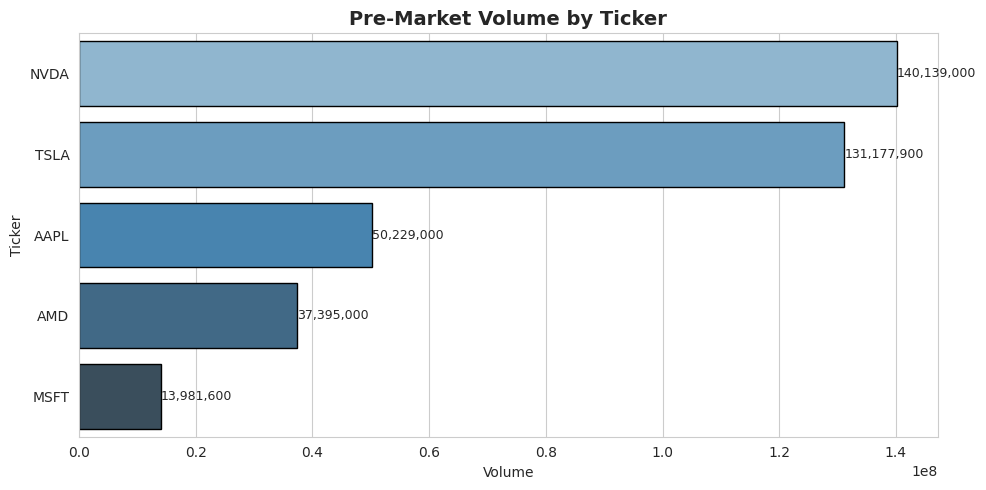

In [8]:
# Sort by volume
df_sorted_vol = df.sort_values("volume", ascending=False)

plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")

barplot = sns.barplot(
    data=df_sorted_vol,
    x="volume",
    y="ticker",
    palette="Blues_d",
    edgecolor='black'
)

plt.title("Pre-Market Volume by Ticker", fontsize=14, weight="bold")
plt.xlabel("Volume")
plt.ylabel("Ticker")

# Add volume annotations
for i, row in df_sorted_vol.iterrows():
    barplot.text(
        row['volume'],
        i,
        f"{int(row['volume']):,}",
        va='center',
        ha='left',
        fontsize=9
    )

plt.tight_layout()
plt.show()

In [9]:
# Save the final filtered_df to CSV
df.to_csv("daily_report.csv", index=False)